In [11]:
import joblib
import torch 
import pandas as pd
import numpy as np
from metpy.calc import wind_components
from metpy.units import units
import openmeteo_requests
import requests_cache
from math import radians, sin, cos, sqrt, atan2
from torch.utils.data import Dataset, DataLoader
from transformers import PatchTSTForPrediction, PatchTSTConfig
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import joblib 
import matplotlib.pyplot as plt
from darts import TimeSeries
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import os
import datetime as dt
import pytz
from retry_requests import retry
from datetime import timedelta

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# API

In [16]:
def get_ordered_hourly_variables(params):
    return params.get("hourly", [])

#setting up API client
cache_session = requests_cache.CachedSession('.cache', expire_after=3600)
retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
openmeteo = openmeteo_requests.Client(session=retry_session)


#Sample use
# df = get_reading("https://api.open-meteo.com/v1/forecast",
#             31.990534, 35.907787,
#             ["temperature_2m", "dew_point_2m", "relative_humidity_2m",
#            "pressure_msl", "wind_speed_10m", "wind_direction_10m"], 5,
#             0)

def get_reading(url, latitude, longtitute, hourly, past_days, future_days):
    params = {
        "latitude": latitude,
        "longitude": longtitute,
        "hourly": hourly,
        "past_days": past_days,
        "forecast_days": future_days
    }

    response = openmeteo.weather_api(url, params=params)[0]
    hourly = response.Hourly()

    # Convert from UTC to UTC+3
    start_time = pd.to_datetime(hourly.Time(), unit="s", utc=True) + pd.Timedelta(hours=3)
    end_time = pd.to_datetime(hourly.TimeEnd(), unit="s", utc=True) + pd.Timedelta(hours=3)

    hourly_data = {
        "date": pd.date_range(
            start=start_time,
            end=end_time,
            freq=pd.Timedelta(seconds=hourly.Interval()),
            inclusive="left"
        )
    }

    for i, var_name in enumerate(get_ordered_hourly_variables(params)):
        hourly_data[var_name] = hourly.Variables(i).ValuesAsNumpy()

    hourly_df = pd.DataFrame(data=hourly_data)
    hourly_df['Date/Time'] = pd.to_datetime(hourly_df['date'], errors='coerce')
    hourly_df.set_index('Date/Time', inplace=True)
    hourly_df.drop(columns=['date'], inplace=True)


    hourly_df.rename(columns={
        "dew_point_2m": "Air Dew Point",
        "temperature_2m": "Air Temperature (OC)",
        "relative_humidity_2m": "Humidity %",
        "pressure_msl": "Atmospheric Pressure",
        "wind_speed_10m": "Wind Speed (MPS)",
        "wind_direction_10m": "Wind Direction (Degrees)"
    }, inplace=True)

    hourly_df.index = hourly_df.index.tz_convert(None)

    u, v = wind_components(
        hourly_df['Wind Speed (MPS)'].values * units('m/s'),
        hourly_df['Wind Direction (Degrees)'].values * units.degree
    )

    hourly_df['Wind_U'] = u.magnitude  
    hourly_df['Wind_V'] = v.magnitude
    hourly_df.Wind_U = hourly_df.Wind_U.round(2)
    hourly_df.Wind_V = hourly_df.Wind_V.round(2)

    hourly_df.drop(columns=["Wind Speed (MPS)", "Wind Direction (Degrees)"], inplace=True)

    return hourly_df

# Functions

In [3]:
#distance fucntion
def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0
    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)
    a = sin(dlat / 2)**2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon / 2)**2
    return R * 2 * atan2(sqrt(a), sqrt(1 - a))

In [4]:
def get_nearest_station(location):
    names = ['aqaba', 'ghor', 'irbid', 'irwaished', 'maan', 'mafraq', 'amman', 'safawi']
 
    coordinates = [            # (latitude, longitude)
    (29.5500, 35.0000),    # Aqabah
    (31.0333, 35.4667),    # Ghor
    (32.5500, 35.8500),    # Irbid
    (32.5000, 38.2000),    # Irwaished
    (30.1667, 35.7833),    # Maan
    (32.3667, 36.2500),    # Mafraq
    (31.7167, 35.9833),    # Amman
    (32.1608, 37.1539),    # Safawi
    ]
    lat, lon = location
    distances = []
    for stat_lat, stat_lon in coordinates:
        distances.append(haversine(lat, lon, stat_lat, stat_lon))
    closest_idx = int(np.argmin(distances))
    return names[closest_idx]

In [5]:

"""
This function takes a 48 hours of input features :'Air Dew Point', 'Air Temperature (OC)', 'Humidity %',
'Atmospheric Pressure', 'Cloud Cover %', 'Wind_U', 'Wind_V', location (latitude, longtitude) and models and transformers directory,
returns closest station name and a single rain probability for next 24 hours
"""
def predict_rain_probability(location, df_48h, models_dir="Models/Precipitation_Models"):
    
    input_features = [
    'Air Dew Point', 'Air Temperature (OC)', 'Humidity %',
    'Atmospheric Pressure', 'Cloud Cover %', 'Wind_U', 'Wind_V',
    'hour_sin', 'hour_cos', 'day_sin', 'day_cos'
    ]
    
    #Find closest station
    station = get_nearest_station(location)

    #Load model and scaler
    scaler = joblib.load(f"{models_dir}/{station}_scaler.pkl")
    model = RainLSTM(input_size=11)
    model.load_state_dict(torch.load(f"{models_dir}/{station}_precipitation_model.pth", map_location=torch.device('cpu')))
    model.eval()

    #preprocessing 
    df = df_48h.copy()
    df['hour'] = df['time'].dt.hour
    df['day_yr'] = df['time'].dt.dayofyear
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['day_sin'] = np.sin(2 * np.pi * df['day_yr'] / 365)
    df['day_cos'] = np.cos(2 * np.pi * df['day_yr'] / 365)

    df[input_features] = scaler.transform(df[input_features])
    input_data = df[input_features].values.astype(np.float32)

    #Padding just in case
    if len(input_data) < 48:
        pad_len = 48 - len(input_data)
        padding = np.repeat(input_data[-1:], pad_len, axis=0)
        input_data = np.vstack([input_data, padding])

    input_tensor = torch.tensor(input_data).unsqueeze(0)  #shape (1, 48, 11)

    with torch.no_grad():
        prob = model(input_tensor).item()

    return {
        "closest_station": station,
        "precipitation_probability": round(prob, 4)
    }

In [6]:
"""
This function takes a 48 hours of input features :'Air Dew Point', 'Air Temperature (OC)', 'Humidity %',
'Atmospheric Pressure', 'Cloud Cover %', 'Wind_U', 'Wind_V', location (latitude, longtitude) and models and transformers directory,
returns cloud cover for next 24 hour time stamps
"""

def predict_cloud_cover(location, df_48h):
    names = ['aqaba', 'ghor', 'irbid', 'irwaished', 'maan', 'mafraq', 'amman', 'safawi']
    coordinates = [
        (29.5500, 35.0000), (31.0333, 35.4667), (32.5500, 35.8500), (32.5000, 38.2000),
        (30.1667, 35.7833), (32.3667, 36.2500), (31.7167, 35.9833), (32.1608, 37.1539),
    ]
    
    station = get_nearest_station(location)
    input_scaler = joblib.load(f"Models/Cloud_Cover_Models/{station}_input_scaler.save")
    target_scaler = joblib.load(f"Models/Cloud_Cover_Models/{station}_target_scaler.save")
    model = load_model(f"Models/Cloud_Cover_Models/{station}_cloud_model.keras")

    #Preprocess input dataframe
    df = df_48h.copy()
   

    df['hour'] = df['time'].dt.hour
    df['month'] = df['time'].dt.month
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

    input_features = ['Air Dew Point', 'Air Temperature (OC)', 'Humidity %',
                      'Atmospheric Pressure', 'Wind_U', 'Wind_V']
    X_input = input_scaler.transform(df[input_features])
    X_input = np.expand_dims(X_input, axis=0)  # Shape: (1, 48, 6)

    y_pred_scaled = model.predict(X_input)
    y_pred = target_scaler.inverse_transform(y_pred_scaled)
    
    return y_pred.flatten()  # Shape: (24,)

In [49]:
def predict_BatchTST_Variables(df_72h: pd.DataFrame, station: str) -> pd.DataFrame:
    input_len = 72
    output_len = 24

    model_dir = r"Models\Other_Vars"
    scaler_path = os.path.join(model_dir, f"{station.lower()}_scaler.pkl")
    final_dir = os.path.join(model_dir, station.lower())

    features = ['Air Dew Point', 'Air Temperature (OC)', 'Humidity %',
                'Atmospheric Pressure', 'Wind_U', 'Wind_V']
    cyclical = ['day_cos', 'day_sin', 'month_cos', 'month_sin', 'hour_cos', 'hour_sin']
    all_features = features + cyclical

    # Make a copy of the last 72 rows
    df = df_72h.copy().iloc[-input_len:]
    
    # Generate cyclical features
    df['day'] = df.index.day
    df['month'] = df.index.month
    df['hour'] = df.index.hour
    df['day_cos'] = np.cos(2 * np.pi * df['day'] / 31)
    df['day_sin'] = np.sin(2 * np.pi * df['day'] / 31)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df.drop(['day', 'month', 'hour'], axis=1, inplace=True)

    # Load scaler and scale data
    scaler: StandardScaler = joblib.load(scaler_path)
    scaled = scaler.transform(df[all_features])
    scaled = pd.DataFrame(scaled, columns=all_features, index=df.index)

    # Prepare input
    x = scaled.values  # shape [72, num_features]
    x_tensor = torch.tensor(x, dtype=torch.float32).unsqueeze(0).to(device)

    predictions_dict = {}
    prediction_times = pd.date_range(start=df.index[-1] + pd.Timedelta(hours=1), periods=output_len, freq="H")

    # Predict for each variable using its corresponding model
    for target_feature in features:
        print(f"Predicting: {target_feature}")
        
        config = PatchTSTConfig(
            context_length=input_len,
            prediction_length=output_len,
            patch_len=24,
            stride=8,
            d_model=128,
            n_heads=8,
            num_encoder_layers=3,
            dropout=0.1,
            head_dropout=0.1,
            num_input_channels=len(all_features),
            num_targets=1,
            scaling="std",
        )

        model = PatchTSTForPrediction(config).to(device)
        model_path = os.path.join(final_dir, f"patchtst_{target_feature.replace(' ', '_')}.pt")
        model.load_state_dict(torch.load(model_path, map_location=device))
        model.eval()

        with torch.no_grad():
            y_pred = model(x_tensor).prediction_outputs.squeeze(0).cpu().numpy()  # shape [24, len(all_features)]

        # Unscale only the target feature
        y_pred_full = np.zeros((output_len, len(all_features)))
        y_pred_full[:, all_features.index(target_feature)] = y_pred[:, all_features.index(target_feature)]
        y_pred_unscaled = scaler.inverse_transform(y_pred_full)[:, all_features.index(target_feature)]

        predictions_dict[target_feature] = y_pred_unscaled

        # Plot
        plt.figure(figsize=(12, 4))
        plt.plot(prediction_times, y_pred_unscaled, label='Predicted', color='red')
        plt.title(f"{target_feature} Forecast - Next 24 Hours")
        plt.xlabel("Time")
        plt.ylabel(target_feature)
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

    # Return predictions as DataFrame
    predictions_df = pd.DataFrame(predictions_dict, index=prediction_times)
    return predictions_df

In [17]:
test = get_reading("https://api.open-meteo.com/v1/forecast",
            31.990534, 35.907787,
            ["temperature_2m", "dew_point_2m", "relative_humidity_2m",
           "pressure_msl", "wind_speed_10m", "wind_direction_10m"], 3,
            0)

C:\Users\abood\AppData\Local\Temp\ipykernel_23076\1824533742.py:39: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  prediction_times = pd.date_range(start=df.index[-1] + pd.Timedelta(hours=1), periods=output_len, freq="H")


Predicting: Air Dew Point


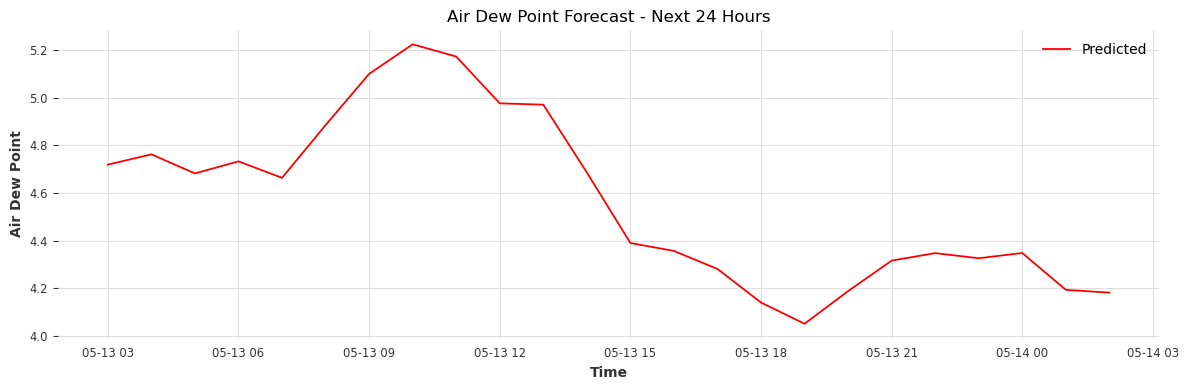

Predicting: Air Temperature (OC)


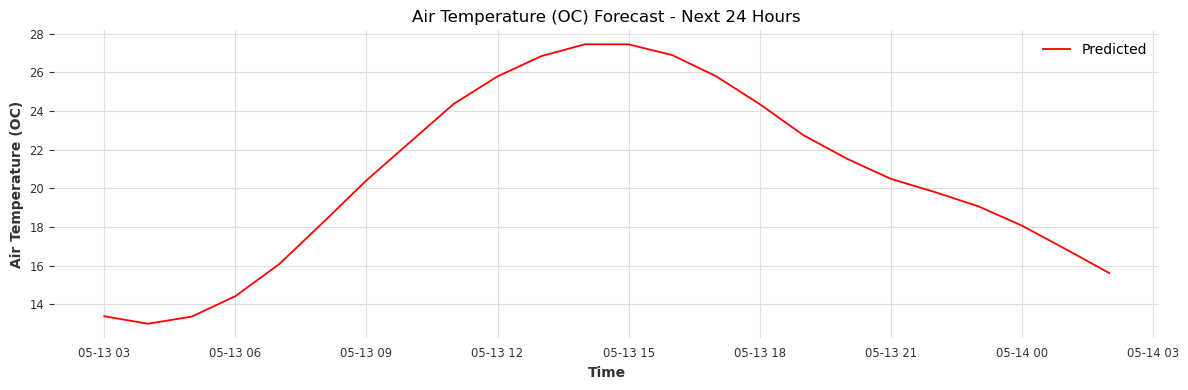

Predicting: Humidity %


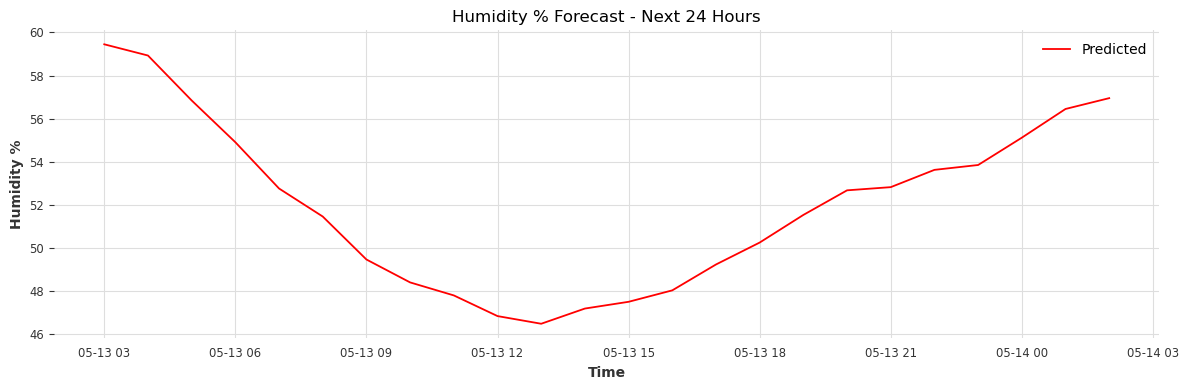

Predicting: Atmospheric Pressure


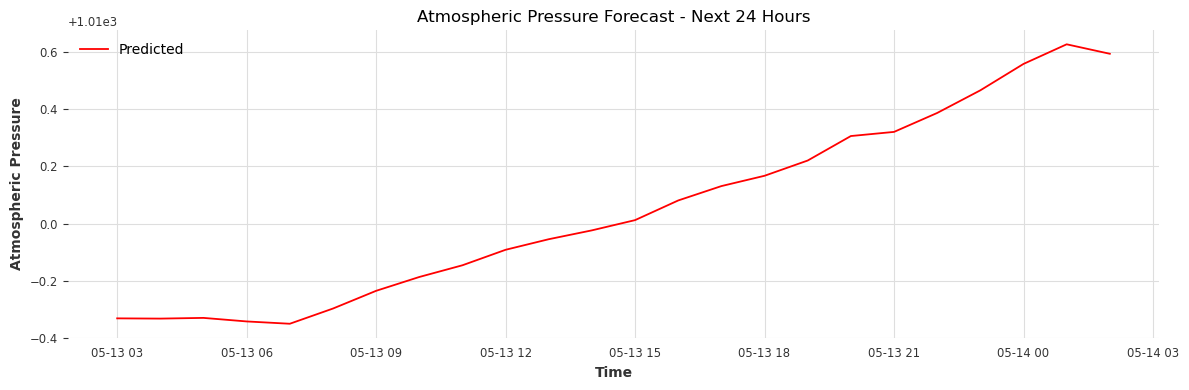

Predicting: Wind_U


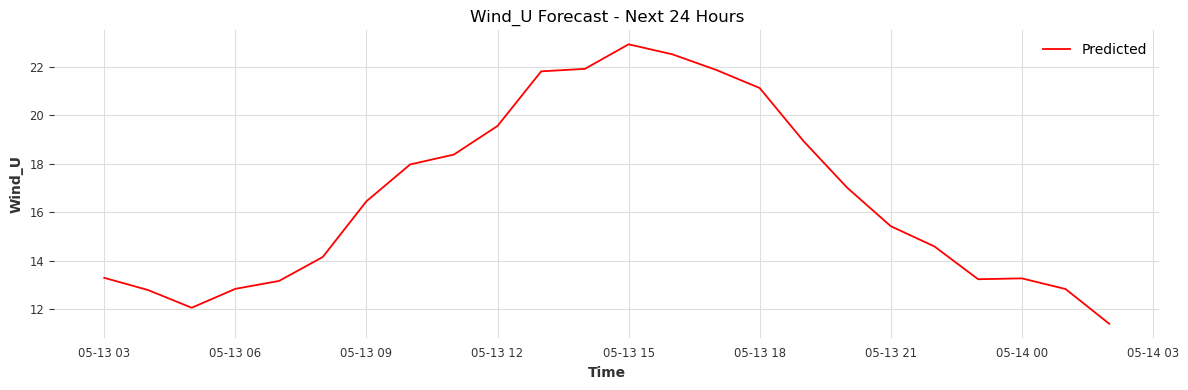

Predicting: Wind_V


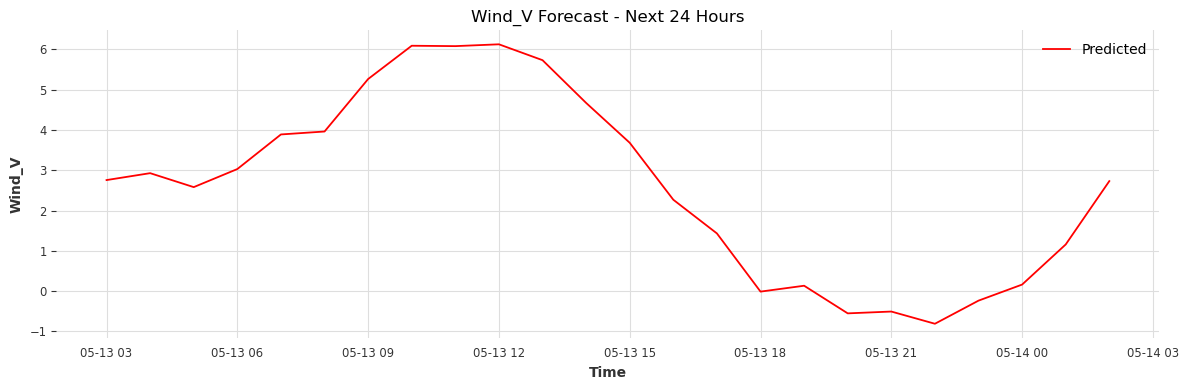

In [50]:
preds = predict_BatchTST_Variables(test, 'amman')

Processing: Air Dew Point


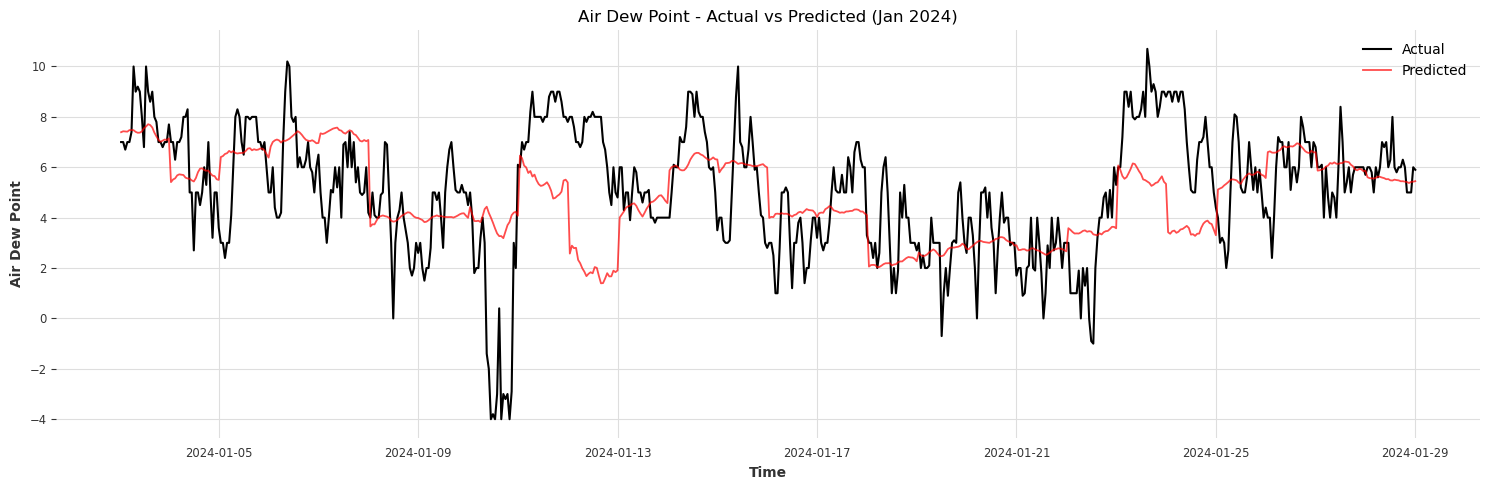

Processing: Air Temperature (OC)


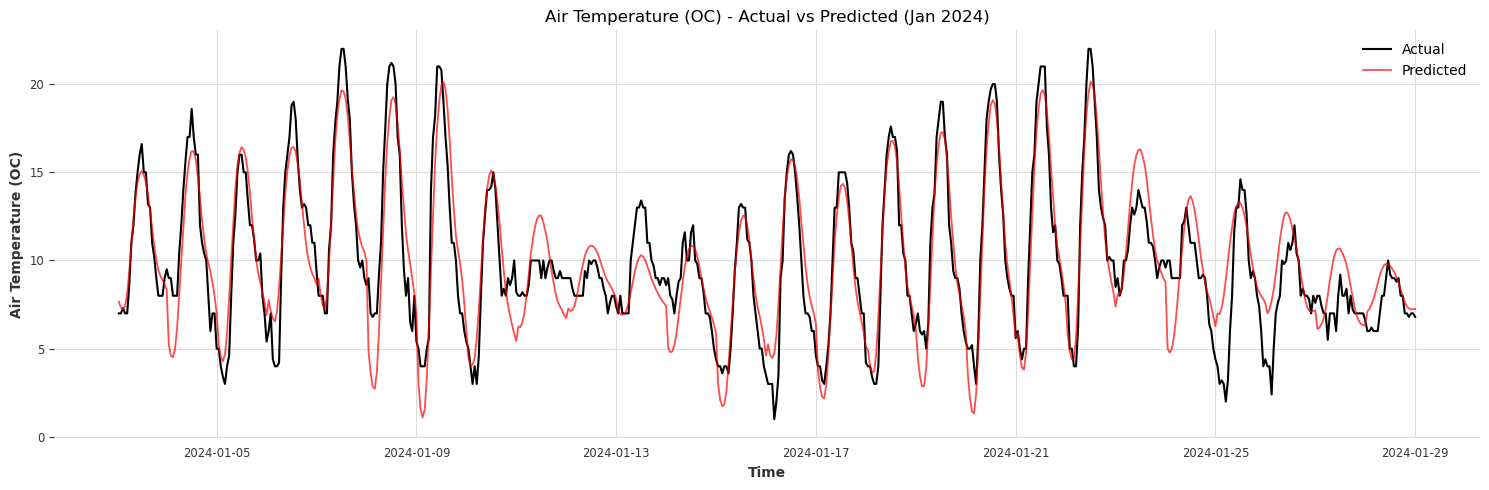

Processing: Humidity %


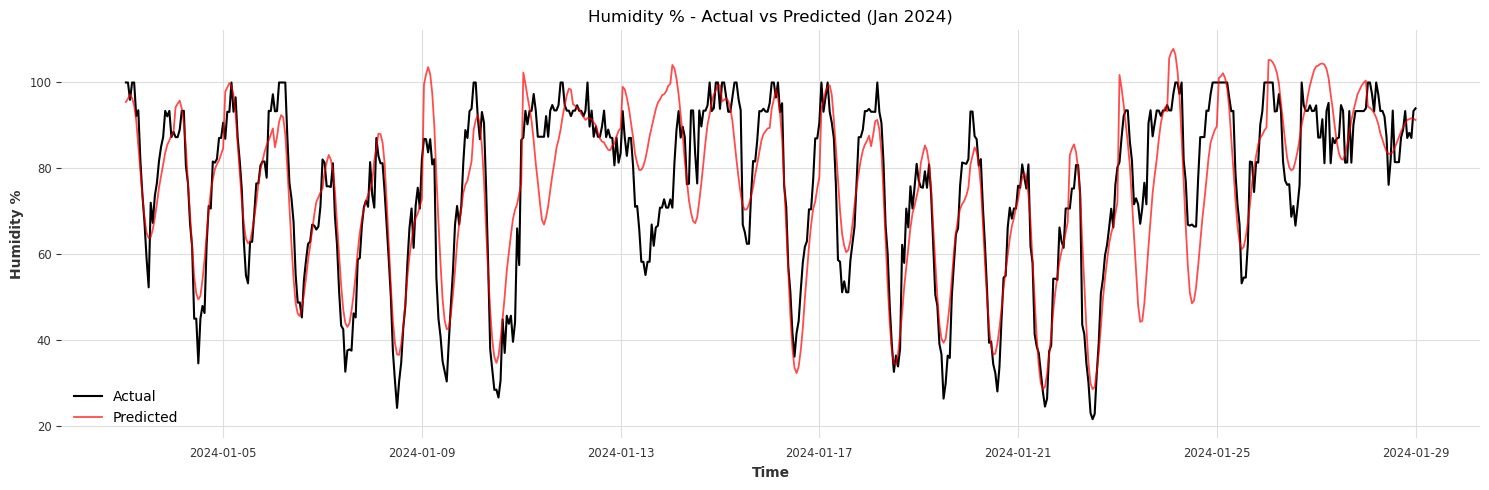

Processing: Atmospheric Pressure


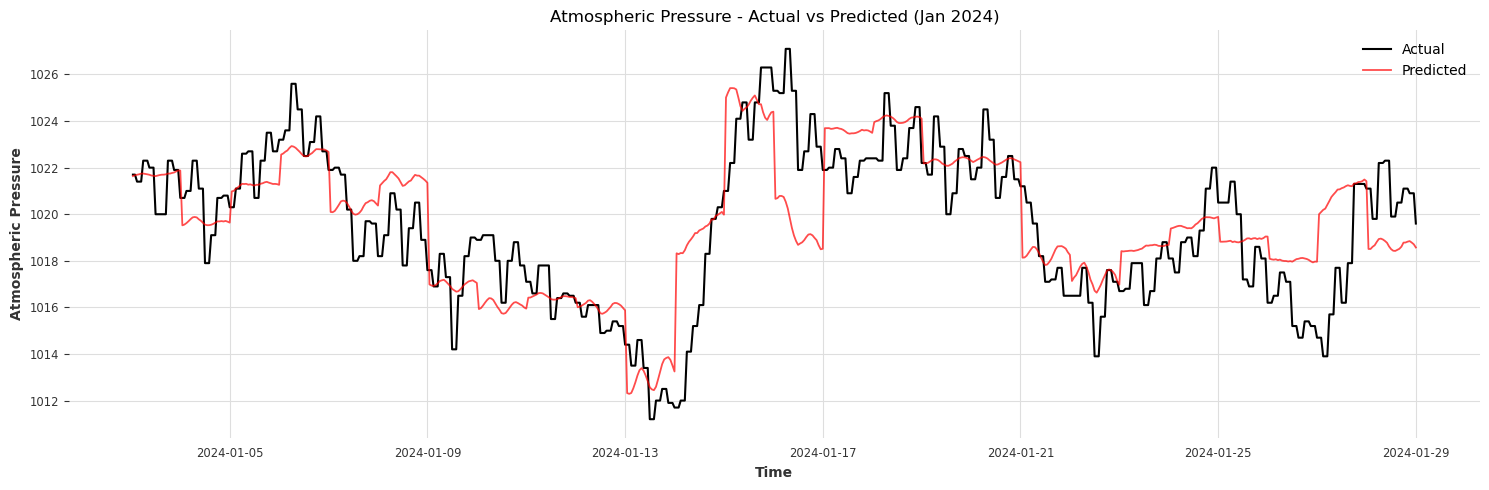

Processing: Wind_U


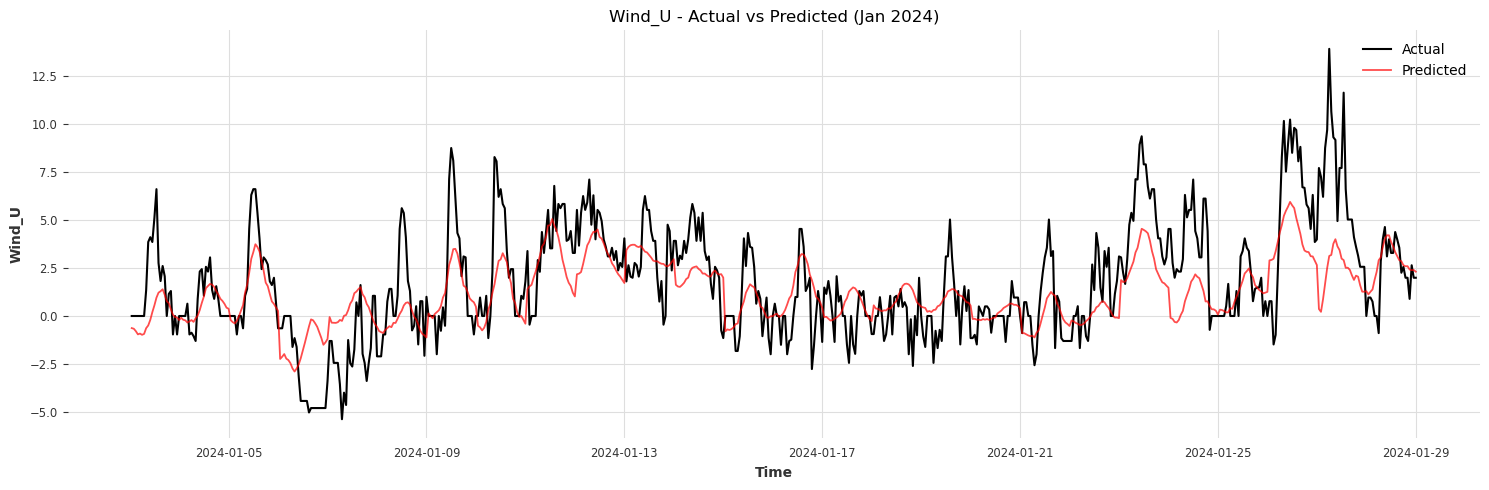

Processing: Wind_V


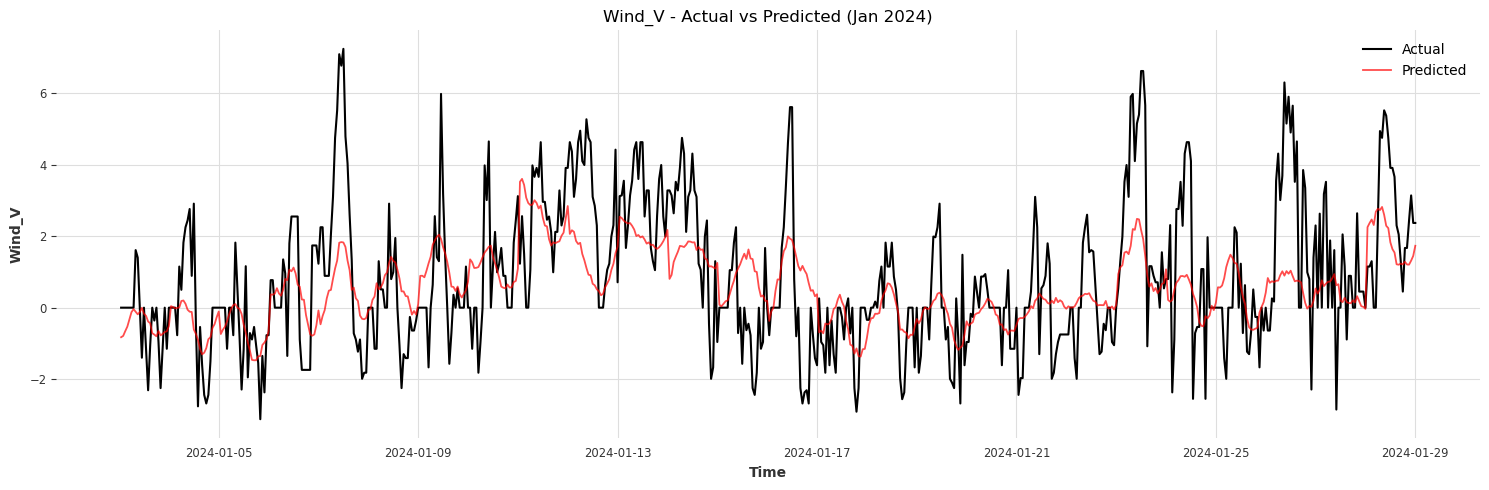

In [46]:
input_len = 72
output_len = 24
model_dir = r"Models\Other_Vars"
scaler_path = os.path.join(model_dir, "amman_scaler.pkl")
final_dir = os.path.join(model_dir, "amman")
features = ['Air Dew Point', 'Air Temperature (OC)', 'Humidity %',
            'Atmospheric Pressure', 'Wind_U', 'Wind_V']
cyclical = ['day_cos', 'day_sin', 'month_cos', 'month_sin', 'hour_cos', 'hour_sin']
all_features = features + cyclical

scaler: StandardScaler = joblib.load(scaler_path)

test_df = pd.read_csv("Amman_test_data/amman_test.csv")
test_df['time'] = pd.to_datetime(test_df['Unnamed: 0'])
test_df = test_df.set_index(test_df['time']).drop(columns=['Unnamed: 0', 'time'])



#Cyclical features
test_df['day'] = test_df.index.day
test_df['month'] = test_df.index.month
test_df['hour'] = test_df.index.hour
test_df['day_cos'] = np.cos(2 * np.pi * test_df['day'] / 31)
test_df['day_sin'] = np.sin(2 * np.pi * test_df['day'] / 31)
test_df['month_cos'] = np.cos(2 * np.pi * test_df['month'] / 12)
test_df['month_sin'] = np.sin(2 * np.pi * test_df['month'] / 12)
test_df['hour_cos'] = np.cos(2 * np.pi * test_df['hour'] / 24)
test_df['hour_sin'] = np.sin(2 * np.pi * test_df['hour'] / 24)
test_df.drop(['day', 'month', 'hour'], axis=1, inplace=True)
#Scale
test_scaled = scaler.transform(test_df[all_features])
test_scaled = pd.DataFrame(test_scaled, columns=all_features, index=test_df.index)
test_scaled = test_scaled[(test_scaled.index > pd.to_datetime('2024-01-01'))
    & (test_scaled.index < pd.to_datetime('2024-01-31'))]
#loop for plot
for target_feature in features:
    print(f"Processing: {target_feature}")
    
    #Load model
    config = PatchTSTConfig(
        context_length=input_len,
        prediction_length=output_len,
        patch_len=24,
        stride=8,
        d_model=128,
        n_heads=8,
        num_encoder_layers=3,
        dropout=0.1,
        head_dropout=0.1,
        num_input_channels=len(all_features),
        num_targets=1,
        scaling="std",
    )
    model = PatchTSTForPrediction(config).to(device)
    
    model_path = os.path.join(final_dir, f"patchtst_{target_feature.replace(' ', '_')}.pt")
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    inputs = test_scaled[all_features].values
    target_actual = test_df[target_feature].values

    predictions = []
    actuals = []
    timestamps = []

    for i in range(input_len, len(inputs) - output_len + 1, output_len):
        x = inputs[i - input_len:i]
        y_true = target_actual[i:i + output_len]

        x_tensor = torch.tensor(x, dtype=torch.float32).unsqueeze(0).to(device)
        with torch.no_grad():
            y_pred = model(x_tensor).prediction_outputs.squeeze(0).cpu().numpy()  # [24, 12]

        y_pred_single = y_pred[:, all_features.index(target_feature)]
        y_pred_full = np.zeros((output_len, len(all_features)))
        y_pred_full[:, all_features.index(target_feature)] = y_pred_single
        y_pred_unscaled = scaler.inverse_transform(y_pred_full)[:, all_features.index(target_feature)]

        predictions.extend(y_pred_unscaled)
        actuals.extend(y_true)
        timestamps.extend(test_df.index[i:i + output_len])

    #Plot and save
    plt.figure(figsize=(15, 5))
    plt.plot(timestamps, actuals, label='Actual', color='black', linewidth=1.5)
    plt.plot(timestamps, predictions, label='Predicted', color='red', alpha=0.7)
    plt.title(f'{target_feature} - Actual vs Predicted (Jan 2024)')
    plt.xlabel('Time')
    plt.ylabel(target_feature)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    
    # Save plot
    plot_filename = f"{target_feature.replace(' ', '_').replace('(', '').replace(')', '')}_Jan2024_Prediction.png"
    plt.savefig(plot_filename, dpi=300)
    plt.show()